In [21]:
# Imports
%reload_ext autoreload
%autoreload 2 
import os
from embed_time.splitter_static import DatasetSplitter
from embed_time.dataset_static import ZarrCellDataset
from embed_time.dataloader_static import collate_wrapper
from embed_time.model import Encoder, Decoder, VAE
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch import optim
import matplotlib.pyplot as plt
import torchview

### Split data

In [22]:
# Usage example:
parent_dir = '/mnt/efs/dlmbl/S-md/'
output_file = '/home/S-md/embed_time/notebooks/splits/example_split.csv'
train_ratio = 0.7
val_ratio = 0.15
num_workers = -1

# Create the dataset split CSV file
DatasetSplitter(parent_dir, output_file, train_ratio, val_ratio, num_workers).generate_split()

Processing 2 genes...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Combining results...
Creating DataFrame and saving CSV...
Dataset split CSV saved to /home/S-md/embed_time/notebooks/splits/example_split.csv


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.6s finished


### Generate dataset

In [23]:
# Usage example:
parent_dir = '/mnt/efs/dlmbl/S-md/'
csv_file = '/home/S-md/embed_time/notebooks/splits/example_split.csv'
split = 'train'
channels = [0, 1, 2, 3]
cell_cycle_stages = 'interphase'
transform = "masks"
crop_size = 100

# Create the dataset
dataset = ZarrCellDataset(parent_dir, csv_file, split, channels, transform, crop_size)

# Print the number of images and shapes of the data
print(f"The dataset contains {len(dataset)} images.")

The dataset contains 13605 images.


### Generate dataloader

In [24]:
# Define the metadata keys
metadata_keys = ['gene', 'barcode', 'stage']
images_keys = ['cell_image']

# Create a DataLoader for the dataset
dataloader = DataLoader(
    dataset, 
    batch_size=16, 
    shuffle=True, 
    collate_fn=collate_wrapper(metadata_keys, images_keys)
)

# Get a batch of data
for i, batch in enumerate(dataloader):
    if i == 0:
        break

### Read in model

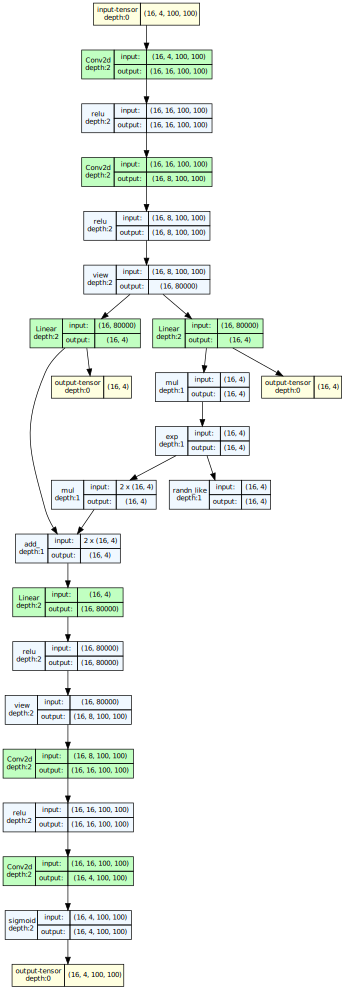

In [26]:
# Initiate Encoder and Decoder
encoder = Encoder(input_shape=(100, 100),
                  x_dim=4,
                  h_dim1=16,
                  h_dim2=8,
                  z_dim=4)
decoder = Decoder(z_dim=4,
                  h_dim1=8,
                  h_dim2=16,
                  x_dim=4,
                  output_shape=(100, 100))

# Initiate VAE
vae = VAE(encoder, decoder)

model_graph = torchview.draw_graph(vae,  
                                   batch['cell_image'],
                                   roll = True,
                                   depth = 3,
                                   device = 'cpu',
                                   save_graph = True,
                                   filename = 'basic_vae_model_graph')

model_graph.visual_graph

In [27]:
assert torch.cuda.is_available()

In [28]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
vae = vae.to(device)

In [29]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='mean')
    print(BCE)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    print(KLD)
    return BCE + KLD

In [30]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, batch in enumerate(dataloader):
        data = batch['cell_image'].to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(dataloader.dataset)))


In [31]:
for epoch in range(1, 10):
    train(epoch)

tensor(1203413.1250, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(909197.4375, device='cuda:0', grad_fn=<MulBackward0>)
Train Epoch: 1 [0/13605 (0%)]	Loss: 132038.156250
tensor(1811780.3750, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7586893.5000, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1286098.7500, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(450387.4375, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1442790.2500, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1295028., device='cuda:0', grad_fn=<MulBackward0>)
tensor(1279760.1250, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3013177., device='cuda:0', grad_fn=<MulBackward0>)
tensor(1436751.1250, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2910596., device='cuda:0', grad_fn=<MulBackward0>)
Train Epoch: 1 [80/13605 (1%)]	Loss: 271709.187500
tensor(1507174.5000, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1007444.7500, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1453394.62